In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import PIL
import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 9.4 MB/s eta 0:00:00


In [ ]:
import patoolib
patoolib.extract_archive('Data.zip')
#Ignore the error here

patool: Extracting Data.zip ...
patool: running /usr/bin/7z x -o./Unpack_ilyq3hbp -- Data.zip


PatoolError: ignored

In [ ]:
img_data = 'Unpack_z379883p/images_original/'

In [ ]:
BATCH_SIZE=8
TARGET_SIZE=224 # Based on EfficientNetB0
NUM_CLASSES=10

In [ ]:
train_ds = image_dataset_from_directory(
  img_data,
  validation_split=0.2,   subset="training",   seed=123,
  image_size=(TARGET_SIZE, TARGET_SIZE),   batch_size=BATCH_SIZE)

Found 999 files belonging to 10 classes.
Using 800 files for training.


In [ ]:
val_ds = image_dataset_from_directory(
  img_data,
  validation_split=0.2,   subset="validation",   seed=123,
  image_size=(TARGET_SIZE, TARGET_SIZE),   batch_size=BATCH_SIZE)

Found 999 files belonging to 10 classes.
Using 199 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


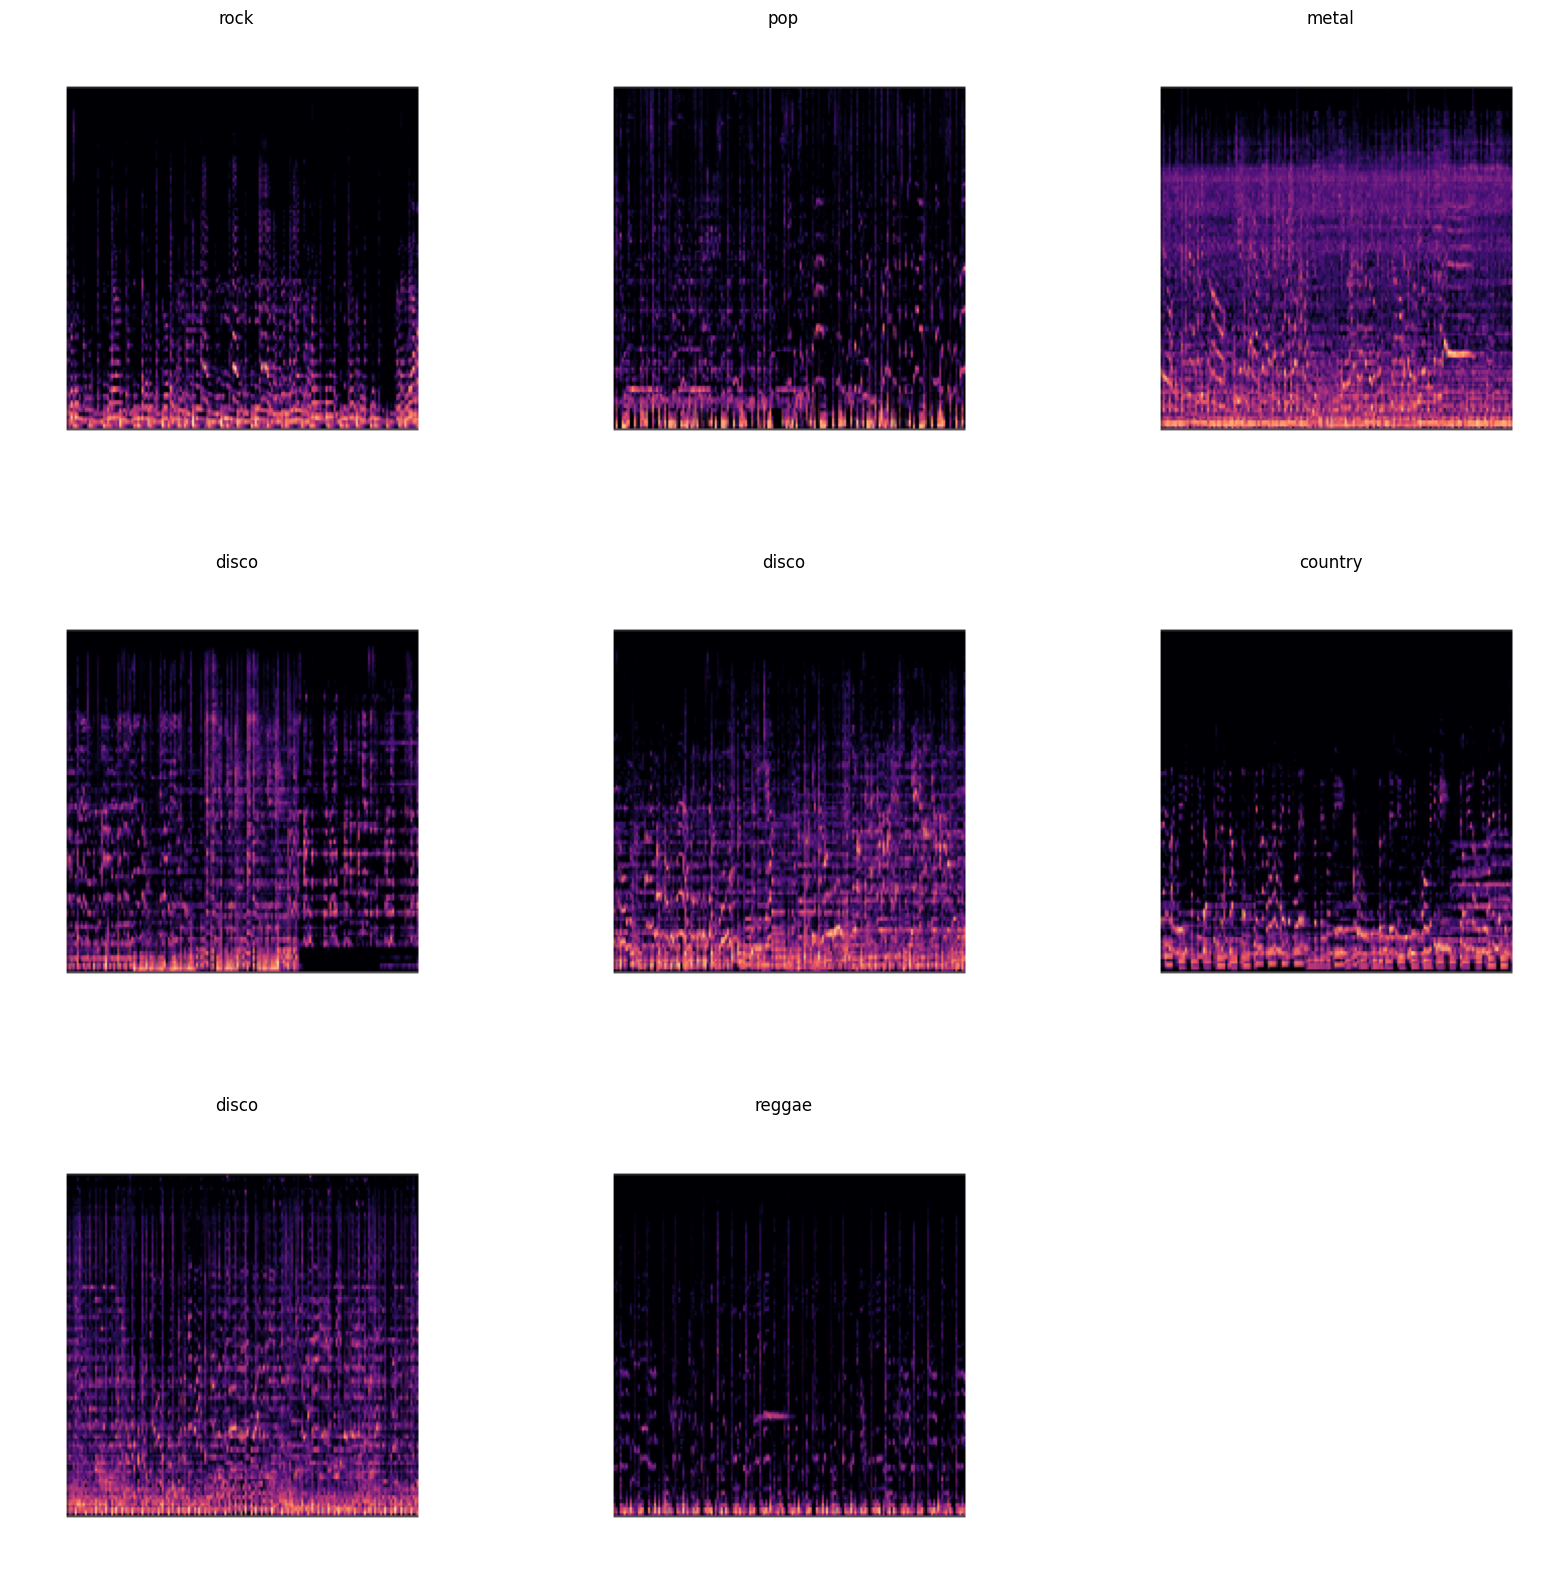

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
model_save = tf.keras.callbacks.ModelCheckpoint('./best_weights.h5',
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)

In [ ]:
def plot_hist(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_CLASSES)
])

In [ ]:
model.compile(optimizer=Adam(lr = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_save, early_stop, reduce_lr],
  verbose=2
)

Epoch 1/30

Epoch 1: val_loss improved from inf to 1.94779, saving model to ./best_weights.h5
100/100 - 12s - loss: 2.3744 - accuracy: 0.1787 - val_loss: 1.9478 - val_accuracy: 0.3166 - lr: 0.0010 - 12s/epoch - 119ms/step
Epoch 2/30

Epoch 2: val_loss improved from 1.94779 to 1.65515, saving model to ./best_weights.h5
100/100 - 2s - loss: 1.7007 - accuracy: 0.4125 - val_loss: 1.6552 - val_accuracy: 0.3819 - lr: 0.0010 - 2s/epoch - 20ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.65515 to 1.59216, saving model to ./best_weights.h5
100/100 - 2s - loss: 1.1329 - accuracy: 0.6125 - val_loss: 1.5922 - val_accuracy: 0.4271 - lr: 0.0010 - 2s/epoch - 15ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.59216 to 1.51997, saving model to ./best_weights.h5
100/100 - 1s - loss: 0.6670 - accuracy: 0.7738 - val_loss: 1.5200 - val_accuracy: 0.5427 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.51997
100/100 - 1s - loss: 0.3635 - accuracy: 0.8687 - v

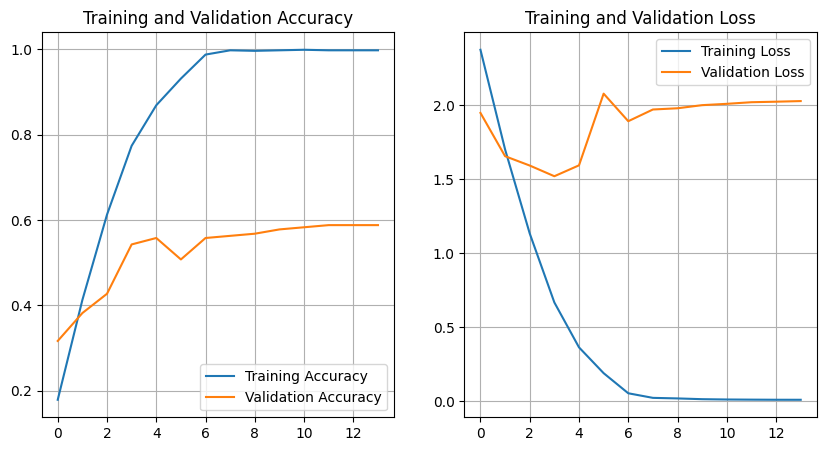

In [ ]:
plot_hist(history)

In [ ]:
TARGET_SIZE

224

In [ ]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_CLASSES)
])
model.compile(optimizer=Adam(lr = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)       

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_save, early_stop, reduce_lr],
  verbose=2
)

Epoch 1/30

Epoch 1: val_loss did not improve from 1.51997
100/100 - 3s - loss: 2.2317 - accuracy: 0.2250 - val_loss: 2.0374 - val_accuracy: 0.2563 - lr: 0.0010 - 3s/epoch - 33ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 1.51997
100/100 - 2s - loss: 1.6797 - accuracy: 0.3925 - val_loss: 1.6309 - val_accuracy: 0.4121 - lr: 0.0010 - 2s/epoch - 15ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.51997 to 1.35206, saving model to ./best_weights.h5
100/100 - 2s - loss: 1.2871 - accuracy: 0.5537 - val_loss: 1.3521 - val_accuracy: 0.4824 - lr: 0.0010 - 2s/epoch - 16ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.35206
100/100 - 1s - loss: 0.8655 - accuracy: 0.6975 - val_loss: 1.4843 - val_accuracy: 0.4774 - lr: 0.0010 - 1s/epoch - 15ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.35206 to 1.27027, saving model to ./best_weights.h5
100/100 - 2s - loss: 0.6266 - accuracy: 0.7950 - val_loss: 1.2703 - val_accuracy: 0.5427 - lr: 0.0010 - 2s/epoch - 16ms/step
Ep

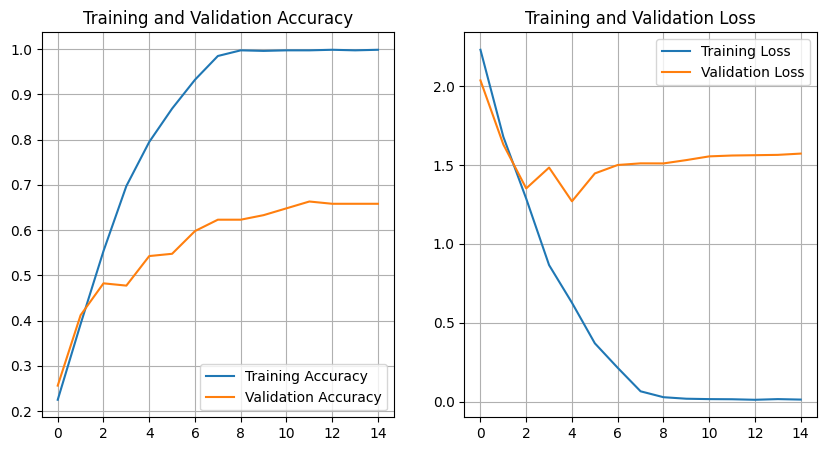

In [ ]:
plot_hist(history)

In [ ]:
# EFFICIENT NET - USUAL WAY OF TRANSFER LEARNING
def create_model():
    conv_base = EfficientNetB0(include_top = False, weights = "imagenet", drop_connect_rate=0.6,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    # Freeze pre-trained layers
    conv_base.trainable = False

    # Re-build top layers
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.BatchNormalization()(model)

    dropout_rate=0.2
    model = layers.Dropout(dropout_rate, name="top_dropout")(model)
    model = layers.Dense(NUM_CLASSES, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.01),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"])
    return model

model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_save, early_stop, reduce_lr],
  verbose=2
)

Epoch 1/30

Epoch 1: val_loss did not improve from 0.82972
100/100 - 10s - loss: 2.1088 - accuracy: 0.3175 - val_loss: 1.7597 - val_accuracy: 0.4422 - lr: 0.0010 - 10s/epoch - 103ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.82972
100/100 - 3s - loss: 1.5850 - accuracy: 0.4800 - val_loss: 1.5294 - val_accuracy: 0.5126 - lr: 0.0010 - 3s/epoch - 26ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.82972
100/100 - 2s - loss: 1.4211 - accuracy: 0.5325 - val_loss: 1.3644 - val_accuracy: 0.5578 - lr: 0.0010 - 2s/epoch - 25ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.82972
100/100 - 2s - loss: 1.3668 - accuracy: 0.5600 - val_loss: 1.3033 - val_accuracy: 0.5779 - lr: 0.0010 - 2s/epoch - 25ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.82972
100/100 - 2s - loss: 1.2353 - accuracy: 0.5788 - val_loss: 1.2885 - val_accuracy: 0.5879 - lr: 0.0010 - 2s/epoch - 25ms/step
Epoch 6/30

Epoch 6: val_loss did not improve from 0.82972
100/100 - 2s - los

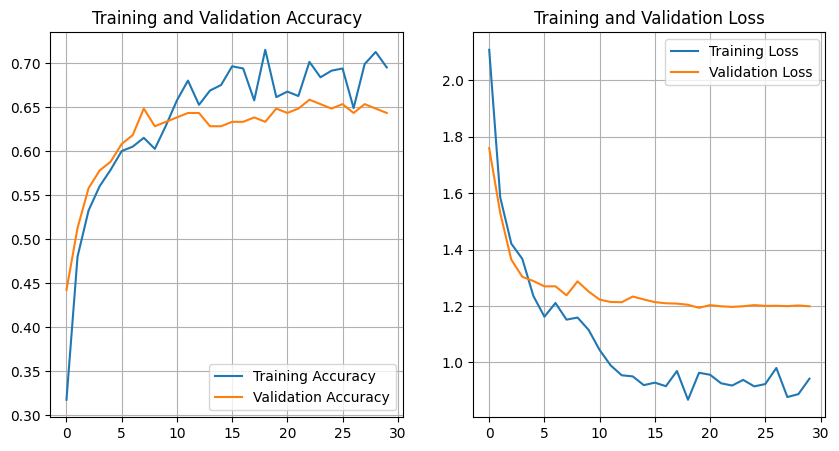

In [ ]:
plot_hist(history)

In [ ]:
weights_path = './first_finetune_weights.h5'
model.save_weights(weights_path)

In [ ]:
# UNFREEZE SOME LAYERS
cont_model = tf.keras.models.clone_model(model)
cont_model.load_weights(weights_path)

NUM_UNFREEZE_LAYERS=100

def unfreeze_model(model):
    # We unfreeze the top NUM_UNFREEZE_LAYERS layers while leaving BatchNorm layers frozen
    for layer in model.layers[-NUM_UNFREEZE_LAYERS:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )


unfreeze_model(cont_model)
cont_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs = 30  # @param {type: "slider", min:8, max:50}
history = cont_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_save, early_stop, reduce_lr],
  verbose=2
)

Epoch 1/30

Epoch 1: val_loss did not improve from 0.82972
100/100 - 20s - loss: 1.1806 - accuracy: 0.5913 - val_loss: 1.4307 - val_accuracy: 0.5427 - lr: 1.0000e-04 - 20s/epoch - 198ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.82972
100/100 - 3s - loss: 1.0208 - accuracy: 0.6425 - val_loss: 1.5362 - val_accuracy: 0.5628 - lr: 1.0000e-04 - 3s/epoch - 33ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.82972
100/100 - 3s - loss: 0.9124 - accuracy: 0.7063 - val_loss: 1.2972 - val_accuracy: 0.5930 - lr: 1.0000e-04 - 3s/epoch - 34ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.82972
100/100 - 3s - loss: 0.8563 - accuracy: 0.7200 - val_loss: 1.4305 - val_accuracy: 0.6131 - lr: 1.0000e-04 - 3s/epoch - 33ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.82972

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
100/100 - 3s - loss: 0.7754 - accuracy: 0.7375 - val_loss: 1.3915 - val_accuracy: 0.6030 - lr: 1.0000e-04 - 

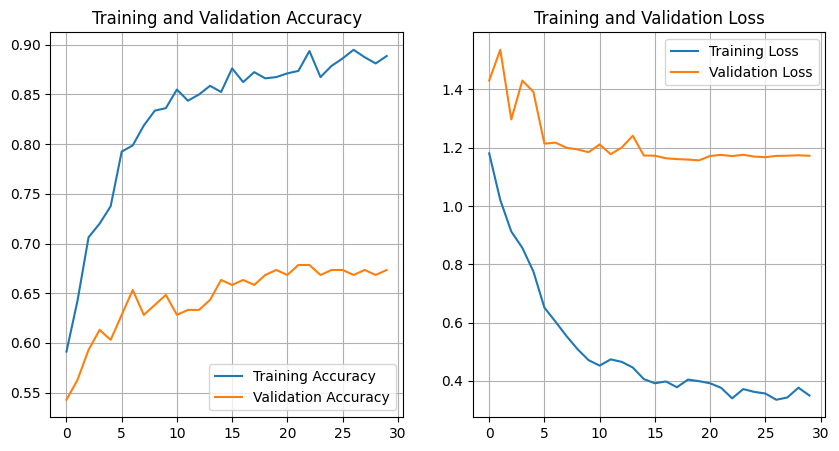

In [ ]:
plot_hist(history)

In [ ]:
#UNFREEZE ALL
cont_model = tf.keras.models.clone_model(model)
cont_model.load_weights(weights_path)

def unfreeze_whole_model(model):
    # We unfreeze the whole layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )


unfreeze_whole_model(cont_model)
cont_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs = 30
history = cont_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_save, early_stop, reduce_lr],
  verbose=2
)

Epoch 1/30

Epoch 1: val_loss did not improve from 0.82972
100/100 - 32s - loss: 1.1744 - accuracy: 0.6100 - val_loss: 1.3334 - val_accuracy: 0.5729 - lr: 1.0000e-04 - 32s/epoch - 318ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.82972
100/100 - 6s - loss: 1.0059 - accuracy: 0.6750 - val_loss: 1.3571 - val_accuracy: 0.5779 - lr: 1.0000e-04 - 6s/epoch - 65ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.82972
100/100 - 7s - loss: 0.9290 - accuracy: 0.6750 - val_loss: 1.3165 - val_accuracy: 0.6080 - lr: 1.0000e-04 - 7s/epoch - 67ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.82972
100/100 - 7s - loss: 0.7906 - accuracy: 0.7312 - val_loss: 1.2587 - val_accuracy: 0.6131 - lr: 1.0000e-04 - 7s/epoch - 66ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.82972
100/100 - 7s - loss: 0.6562 - accuracy: 0.7975 - val_loss: 1.1207 - val_accuracy: 0.6533 - lr: 1.0000e-04 - 7s/epoch - 67ms/step
Epoch 6/30

Epoch 6: val_loss did not improve from 0.8297

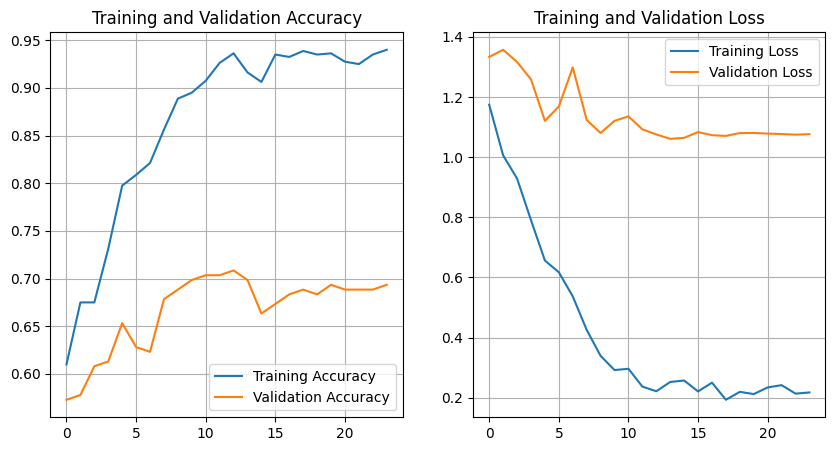

In [ ]:
plot_hist(history)